    1만개의 input node, 128개의 hidden node를 만들어낼 것. 만개라는 숫자는 vocab size하고 동일. 다시 말해 1만개의 단어를 다룬다는 것. 처리할 수 있는 어휘의 범위가 1만이라는 것. 그 1만개의 범위를 벗어나는 단어는 unknown으로 처리해버린다. 원핫코딩, 이진법으로 숫자를 처리하는 방식이 적용된다. 제1째이자 0번째인덱스인 단어는 '0' 5천번째이자 5001번째 인덱스인 단어는 '1' 이런 식으로. 근데 이 모델의 핵심은 단어만을 처리하는 것이 아니라 문장을 처리하는 것.
    1x10,000(input_layer) - 10,000x128(weight) - 128x1(weight) - 1x1(output_layer) 이런 그림이 된다. 근데 여기에 batch size를 생각해보면, 앞에 1x10,000에서 꼭 1일 필요가 없다는 것. 다시 말해, 만약 리뷰할 단어가 3개라면 3x10,000이라는 것이다. 여기서 가장 중요한 점은, 몇개의 단어가 input이 되든, output에는 반드시 1개가 나와야 한다는 것이다.(좋고 싫고 둘 중 하나만)
    input값이 100x10,000일 때, 가운데 히든레이어가 100x128이 될것, 여기서 우리는 1x128이 되기를 원하기 때문에, 100을 1로 압축해야 하는데 여기서 평균을 내서 쓴다. 


In [1]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

# load data
#### dataset (x: imdb article -> y: text type)
#### word2idx dict (key: word; value: index)

텍스트 데이터와 더불어 x(리뷰 테스트 자체) y(호 불호) word2idx는 사전이다. x_train에는 단어들의 번호값이 들어있고 y_train에는 0,1 사이의 좋고싫고를 나타내는 숫자. vocab size 를 1만으로 설정하는 순간, x_train을 구성하는 숫자들 중 1만을 넘는 숫자는 존재하지 않게 된다. 

In [2]:
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.imdb.load_data(num_words=vocab_size)
word2idx = tensorflow.keras.datasets.imdb.get_word_index()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [3]:
print(x_train.shape)
print(x_train[0])
print(y_train.shape)
print(y_train[0])

(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
(25000,)
1


# modifiy word2idx dict (to reflect x_train, x_text)

k,v를 계속 바꿔주는 것. 만약 (k:v+3)이 아니라 (k:v) 라면, 변하는 것이 없을것. +3은 모든 word2idx 사전에 있는 단어들의 인덱스값에 3을 더하는것이 전부다. 이걸 하는 이유는 밑에 패드, 스타트, 언노운, 언유즈드를 넣기 위함이다. 

In [4]:
word2idx = {k:v+3 for k, v in word2idx.items()}
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

# create idx2word: inverse of word2idx

인버스 사전을 또 만들어야 한다. key부분을 넣으면 value 값이 나온다. 숫자를 넣었을 때 무슨 단어인지 참조하기 위해 위에 word2idx와는 반대된 사전을 하나 만든 것. 

In [12]:
idx2word = {v:k for k, v in word2idx.items()}

# padding x_train, x_test

In [13]:
print(x_train[0])
len(x_train[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

256

길이를 256으로 만드는 과정을 패딩이라고 한다. 패딩 방식이 post. 패딩을 리뷰의 앞이 아니라 뒤에 하는것을 post 방식인것. pad의 인덱스값으로 패딩을 하라는 것이 value=word2idx ['<PAD>'] 이 부분이다. 1번째, 즉 0번째인덱스의 리뷰가 이렇다. 

In [14]:
x_train = pad_sequences(x_train, value=word2idx['<PAD>'], padding='post', maxlen=256)
x_test = pad_sequences(x_test, value=word2idx['<PAD>'], padding='post', maxlen=256)

# create model

embedding 뒤에 ,256을 추가할 수 있다. 이 256은 input_length 이다. embedding은 vocab size만큼의 동그라미가 순식간에 나타난다. 우리가 vocab size를 1만으로 했으니 1만개의 동그라미인것. 만약 756이 들어온다면 756번째 동그라미가 1인것 밑에 이진법처럼 표현하는것. 그 다음, 128개의 node가 또 생긴다. 훈련되어야 할 파라미터(weight)는 1만개 layer와 128개 layer사이의 파라미터들이다. 근데 리뷰를 256글자로 했고, 최초에 256x1의 node가 input이 되는것이기 때문에, 256x10,000 그뒤는 10,000x128개의 weight를 거쳐 256x128개 노드의 히든레이어, 그리고 128x1의 weight를 거쳐 1 혹은 0이 나오게 된다. 그런데 이대로라면 마지막에 256x1이 나오게 된다. 256x128개 노드의 히든레이어 이후 128x1의 weight를 거치면 256x1이 나온다. 그렇기 때문에 256x128개 노드의 히든레이어에서 앞에 256부분을 평균을 내는것이다. 그래서 1x128으로 수정을 하는것. globalaveragepooling이 이런 역할을 하는것. 앞부분은 embedding, 뒷부분은 dense.  

embedding이 무엇인가. x train 즉 리뷰를 이루는 숫자들을 원핫코딩(이진법)으로 표현하는 것. 만의 자리까지의 이진법으로 나타내는 것. 패딩을 거친 256개의 숫자를, 리뷰를, 256x10,000의 행렬벡터로 바꾸는 방법이 embedding이다. 0부터 9999까지의 숫자들은 1만개의 이진법으로 표현된 수에서 1이 1째부터 1만째 자리 중 어디에 위치하느냐에 따라 숫자가 정해지는것. 만약 256x10,000의 행렬벡터에서 1의 총 개수는 256개. 왜냐하면 어쨌든 256개의 숫자들 중 자리수가 어디인진 명확하지 않아도 1이 각각 하나씩은 들어있기 때문. 0의 개수는 255x10,000임을 알 수 있다. 

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [17]:
Adam = tensorflow.keras.optimizers.Adam
model.compile(optimizer = Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
print(model.input_shape)
print(model.output_shape)

(None, None)
(None, 1)


# train model

In [19]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.33)

Train on 16750 samples, validate on 8250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
16750/16750 [==============================] - 25s 1ms/sample - loss: 0.6573 - acc: 0.7072 - val_loss: 0.5899 - val_acc: 0.7838
Epoch 2/10
16750/16750 [==============================] - 23s 1ms/sample - loss: 0.5078 - acc: 0.8257 - val_loss: 0.4466 - val_acc: 0.8378
Epoch 3/10
16750/16750 [==============================] - 24s 1ms/sample - loss: 0.3882 - acc: 0.8683 - val_loss: 0.3698 - val_acc: 0.8615
Epoch 4/10
16750/16750 [==============================] - 23s 1ms/sample - loss: 0.3225 - acc: 0.8866 - val_loss: 0.3305 - val_acc: 0.8737
Epoch 5/10
16750/16750 [==============================] - 23s 1ms/sample - loss: 0.2817 - acc: 0.9007 - val_loss: 0.3075 - val_acc: 0.8802
Epoch 6/10
16750/16750 [==============================] - 23s 1ms/sample - loss: 0.2523 - acc: 0.9113 - val_loss: 0.2938 - val_acc: 0.8842
Epoch 7/10
16750/16750 [==============================] - 24s 1ms/sam

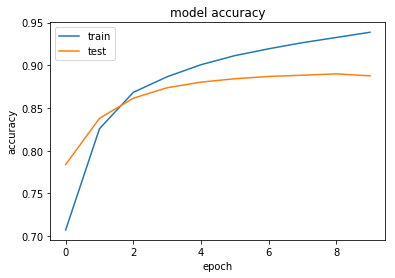

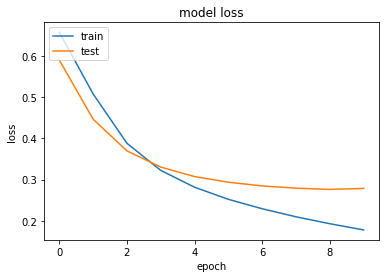

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model

In [21]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 4s 142us/sample - loss: 0.2911 - acc: 0.8801


[0.29107241452217103, 0.88012]

# inference

In [ ]:
testID = 100
print(' '.join([idx2word[idx] for idx in x_test[testID]]))

out = model.predict(x_test[testID].reshape(1,256))
print(y_test[testID])
print(out)